In [18]:
import networkx as nx
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.circuit import Parameter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
graph_nodes = [[0, 1, 2, 3], 
               [0, 1, 2, 3],
               [0, 1, 2, 3, 4],
               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]


graph_edges = [[(0, 1), (1, 2), (2, 3), (3, 0)],
               [(0, 1), (1, 2), (2, 3), (3, 0), (1,3)],
               [(0, 1), (1, 2), (2, 3), (3, 0), (2,4), (3,4)],
               [(0,1), (0,2), (1,3), (1,4), (2,3), (3,4), (3,5), (4,5), (4,6), (5,9), (5,8), (5,6), (6,7), (7,10), (8,9), (8,10)]]

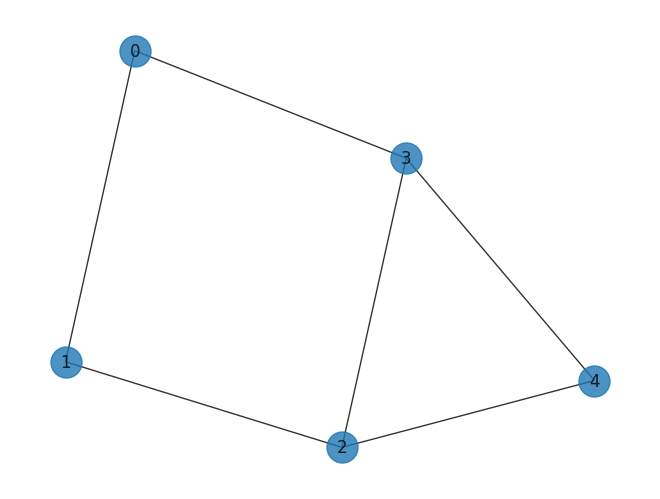

In [26]:
x = 2 # pick which graph we want to use

graph = nx.Graph()
graph.add_nodes_from(graph_nodes[x])
graph.add_edges_from(graph_edges[x])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

The Mixing Unitary

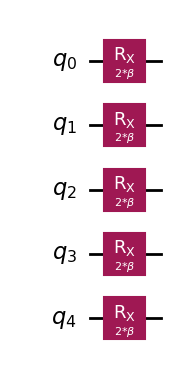

In [27]:
# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(graph).todense()

N_QUBITS = len(graph.nodes())

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_mix.rx(2 * beta, i)

qc_mix.draw('mpl')

The Problem Unitary

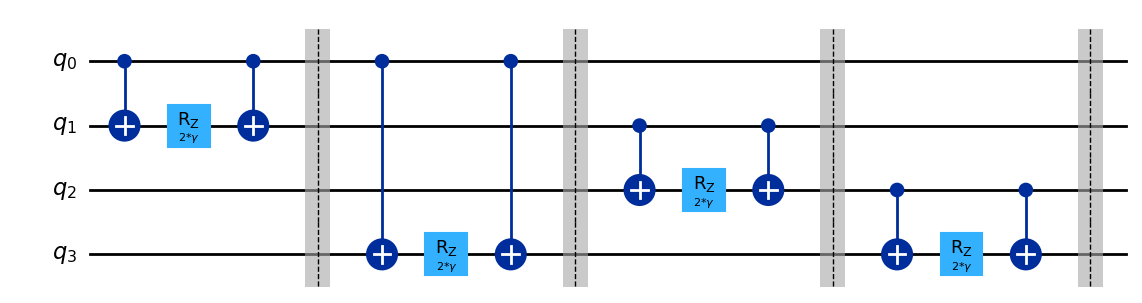

In [8]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes per egde
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw('mpl',fold=False, idle_wires=False)

The Initial State - put into superposition

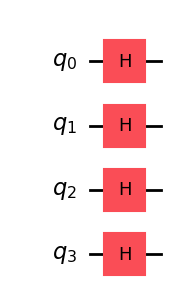

In [9]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw('mpl')

The QAOA Circuit

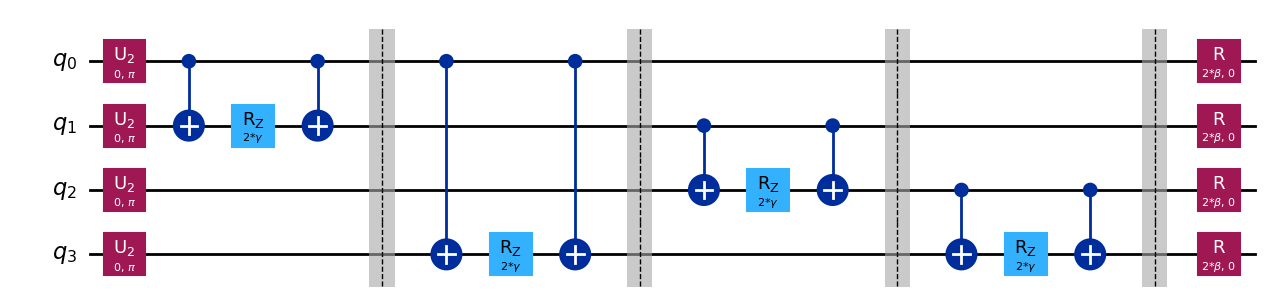

In [10]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw('mpl',fold=False, idle_wires=False)

In [31]:
def cut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    # pylint: disable=invalid-name
    obj = 0
    cut = 0
    partition_sum = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            cut += 1 

    for k in solution:
        if k == 0:
            partition_sum += 1
        else:
            partition_sum -= -1

    partition_sum = abs(partition_sum) # make 
    
    obj = cut + partition_sum**2

    return obj

In [13]:

def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = cut_obj(bit_string, graph)
        #print(str(bit_string) + ":" + str(obj))
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [14]:
# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc

In [20]:
objective_func_vals = [] 

#Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        cost = compute_expectation(counts, graph)
        objective_func_vals.append(cost) 
        return cost

    return execute_circ

In [32]:
from scipy.optimize import minimize

objective_func_vals = []
expectation = get_expectation(graph)
print(expectation)

res = minimize(expectation,
               [np.pi, np.pi/2],
               method='COBYLA',
               tol=1e-2)
res

<function get_expectation.<locals>.execute_circ at 0x00000223436FF380>


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 27.9833984375
       x: [ 3.142e+00  1.571e+00]
    nfev: 7
   maxcv: 0.0

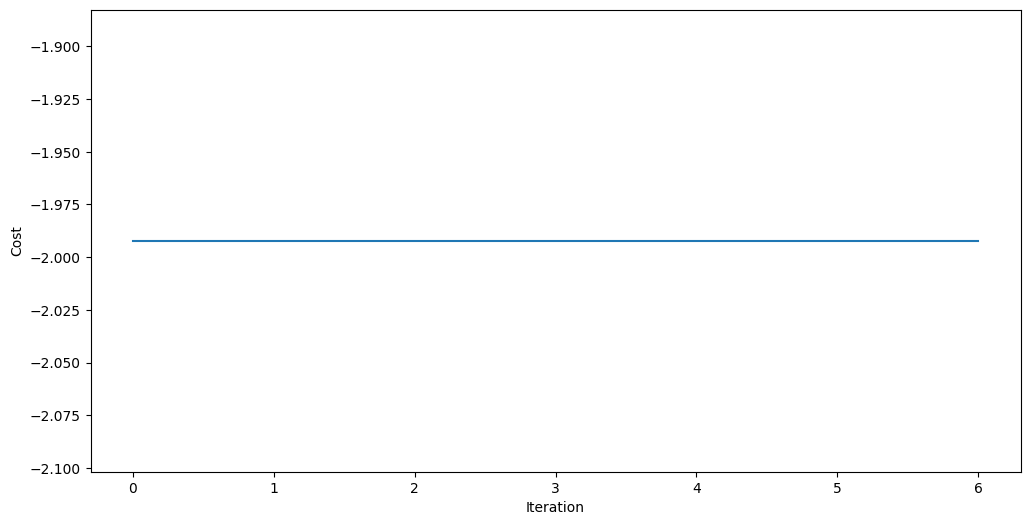

In [22]:
#TODO: Iteration plot not working - adjust how cost values are  getting in

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Analyzing the result

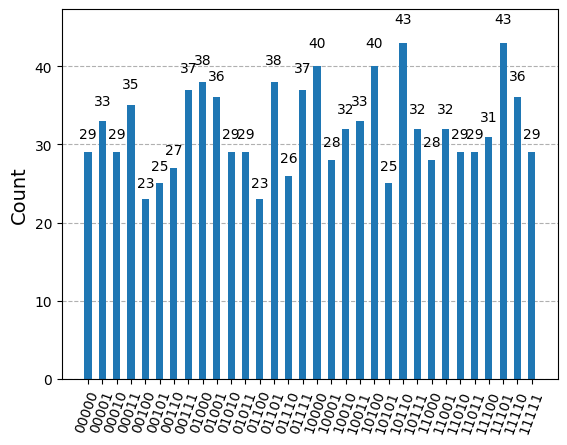

In [33]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

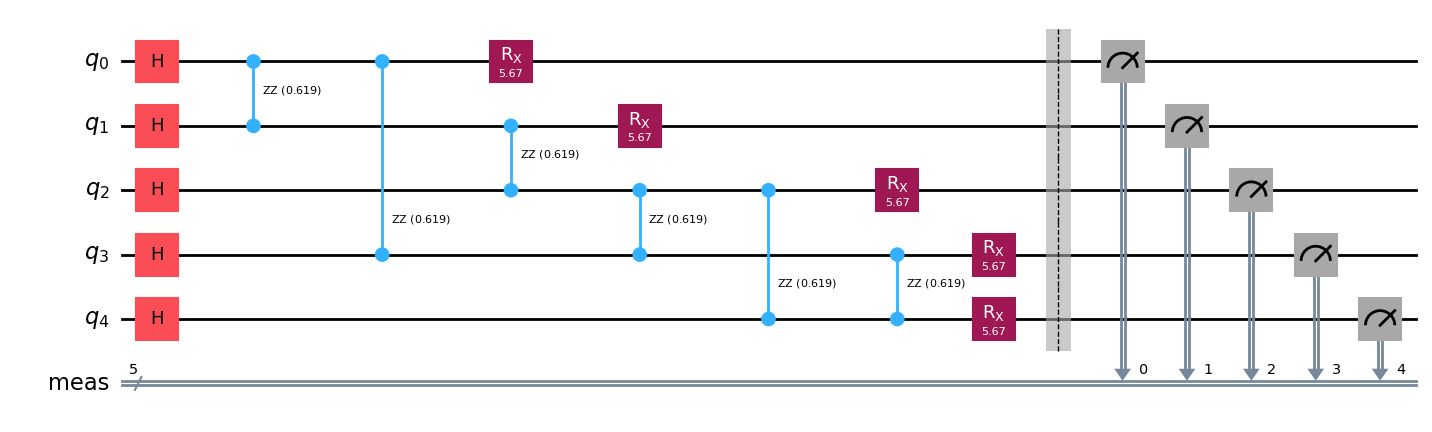

In [117]:
qc_res.draw('mpl')

In [1]:
import qiskit
qiskit.version.get_version_info()

'1.1.0'

In [2]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.23.0'